In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from astropy.io import ascii
import emcee as emcee
from astropy import constants, units
import os
import corner
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import gaussian_kde

In [5]:
## initialize a dataframe which will store parameter values for different datasets and models

# model_data_combos_df = pd.DataFrame(columns=['Data Files','Frequencies','Intensities','Errors','Model','Dimensions','Parameter Values','X2'])
# model_data_combos_df.to_csv('/Users/calebpainter/Downloads/research/Disks/codes/model_data_combos_df2.csv',index=False)

model_data_combos_df = pd.read_csv('/Users/calebpainter/Downloads/research/Disks/codes/model_data_combos_df.csv',index_col=False)

In [6]:
model_data_combos_df

,Unnamed: 0,Data Files,Frequencies,Intensities,Errors,Model,Dimensions,Parameter Values,X2
0,0,"{'File Type:': 'vis', 'Non-VLA Archive and Cut...",[ 45.64033322 41.80042073 33.96032224 35.94...,[3.05649073e+03 2.63700865e+03 1.63701735e+03 ...,[1.07183422e+02 7.27612073e+01 3.64536105e+01 ...,three power law,7,"{'$S_v^{cont}$': 917.198522706243, '$S_v^{dust...",504.985827
1,1,"{'File Type:': 'img', 'Non-VLA Archive and Cut...",[ 44.99643104 46.99631686 40.99665939 42.95...,[3.53998276e+03 3.65664082e+03 2.32170271e+03 ...,[5.03056686e+02 5.14356426e+02 2.99620300e+02 ...,three power law,7,"{'$S_v^{cont}$': 864.9030683567005, '$S_v^{dus...",326.922245
2,2,"{'File Type:': 'img', 'Non-VLA Archive and Cut...",[ 44.99643104 46.99631686 40.99665939 42.95...,[3.53998276e+03 3.61940309e+03 2.32170271e+03 ...,[5.03056686e+02 5.09316865e+02 2.99620300e+02 ...,three power law,7,"{'$S_v^{cont}$': 864.3066552960811, '$S_v^{dus...",328.015433
3,3,"{'File Type:': 'img', 'Non-VLA Archive and Cut...",[ 44.99643104 46.99631686 40.99665939 42.95...,[3.42451349e+03 4.05000209e+03 2.42270003e+03 ...,[4.81674004e+02 5.55050086e+02 2.97979732e+02 ...,three power law,7,"{'$S_v^{cont}$': 892.2121261688894, '$S_v^{dus...",313.056049
4,4,"{'File Type:': 'img', 'Non-VLA Archive and Cut...",[ 44.99643104 46.99631686 40.99665939 42.95...,[3.59678932e+03 3.94003729e+03 2.50857883e+03 ...,[5.11836640e+02 5.48749844e+02 3.08570566e+02 ...,three power law,7,"{'$S_v^{cont}$': 861.4904035060304, '$S_v^{dus...",290.495567


In [35]:
image_np= np.load('/Users/calebpainter/Downloads/research/Disks/data/MWC480_NOEMA.imf_fluxes.npz')
nu_noema, Snu_noema, err_Snu_noema = image_np['nu'], image_np['Snu'], image_np['eSnu']


In [36]:
nu_noema

array([ 80.22440261,  84.28688547,  95.71424372,  99.77672658,
        88.22437661,  92.2868958 , 103.71435622, 107.77687541,
       130.22694433, 134.28877738, 145.71430777, 149.77614082,
       138.22643538, 142.2889276 , 153.71631218, 157.7788044 ])

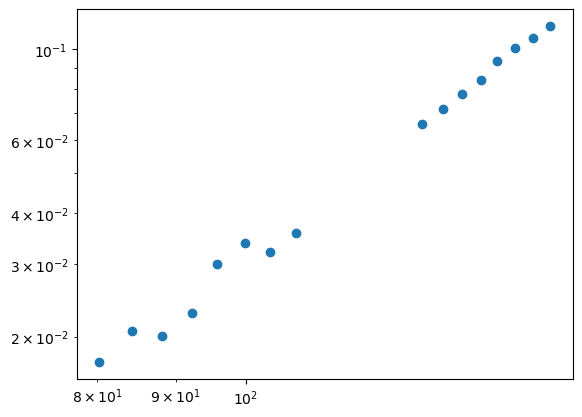

In [12]:
plt.scatter(nu_img, Snu_img)
plt.xscale('log')
plt.yscale('log')

In [159]:
# define data directories

def get_data_version(file_type, archive,file_number,non_vla_freq_index_cutoff):
    dir_name = '/Users/calebpainter/Downloads/research/Disks/data/'
    image_files = os.listdir('/Users/calebpainter/Downloads/research/Disks/data/image')

    # non-VLA archival
    non_vla = ascii.read("/Users/calebpainter/Downloads/research/Disks/data/MWC480.spec.txt")  
    lambda_non_vla, snu_non_vla, snu_err_non_vla = non_vla['col1'], non_vla['col2'], non_vla['col3']
    nu_non_vla = np.array([(constants.c/(units.micron * x)).to(units.GHz).value for x in lambda_non_vla])

    print(nu_non_vla)

    # set what data you want (vis vs imge, include archival or no, which image data you want, when you want vla_freq cutoff to be)

    # record as the data files
    data_version = {
        'File Type:': file_type,
        'Non-VLA Archive and Cutoff': (archive, non_vla_freq_index_cutoff),
        'File Number (if multiple)': file_number
    }


    if file_type == 'img':
        image_np= np.load(dir_name+f'/image/{image_files[file_number]}')
        nu_img, Snu_img, err_Snu_img = image_np['nu'], image_np['Snu'], image_np['eSnu']

    
        if archive == True:

            nu_hz_combined_img = np.array(list(nu_img*(10**9)) + list(nu_non_vla*(10**9))[non_vla_freq_index_cutoff:])
            snu_uJy_combined_img = np.array(list(Snu_img*(10**6)) + list(snu_non_vla*(10**6))[non_vla_freq_index_cutoff:])
            snu_err_uJy_combined_img = np.array(list(err_Snu_img*(10**6)) + list(snu_err_non_vla*(10**6))[non_vla_freq_index_cutoff:])

            mcmc_nu = nu_hz_combined_img
            mcmc_Snu = snu_uJy_combined_img
            mcmc_Snu_err= snu_err_uJy_combined_img

        elif archive == False:
            mcmc_nu = nu_img
            mcmc_Snu = Snu_img
            mcmc_Snu_err= err_Snu_img

    elif file_type == 'vis':
        # visibility-based spectrum
        _ = np.load(dir_name+'MWC480.vis_fluxes.npz')
        nu_vis, Snu_vis, err_Snu_vis = _['nu'], _['Fnu'], _['eFnu']

        if archive == True:

            nu_hz_combined_vis = np.array(list(nu_vis) + list(nu_non_vla*(10**9))[non_vla_freq_index_cutoff:])
            snu_uJy_combined_vis = np.array(list(Snu_vis) + list(snu_non_vla*(10**6))[non_vla_freq_index_cutoff:])
            snu_err_uJy_combined_vis = np.array(list(err_Snu_vis) + list(snu_err_non_vla*(10**6))[non_vla_freq_index_cutoff:])

            mcmc_nu = nu_hz_combined_vis
            mcmc_Snu = snu_uJy_combined_vis
            mcmc_Snu_err= snu_err_uJy_combined_vis

        elif archive == False:
            mcmc_nu = nu_vis
            mcmc_Snu = Snu_vis
            mcmc_Snu_err= err_Snu_vis


    ## convert all frequencies to GHz
    mcmc_nu = mcmc_nu/(10**9)

    # add calibration errors as list
    flux_scale_errors = np.zeros(len(mcmc_nu))

    indices_17Ghz = np.where(mcmc_nu < 17)[0] 
    indices_50Ghz = np.where((mcmc_nu < 50) &(mcmc_nu > 17) )[0] 
    indices_100Ghz = np.where(mcmc_nu > 50)[0] 

    flux_scale_errors[indices_17Ghz] = .03
    flux_scale_errors[indices_50Ghz] = .05
    flux_scale_errors[indices_100Ghz] = .1

    ## add in NOEMA data
    image_np= np.load('/Users/calebpainter/Downloads/research/Disks/data/MWC480_NOEMA.imf_fluxes.npz')
    nu_noema, Snu_noema, err_Snu_noema = image_np['nu'], image_np['Snu'], image_np['eSnu']

    NOEMA_flux_scale_errors = np.zeros(len(nu_noema))

    indices_lower = np.where(nu_noema < 110)[0] 
    indices_upper = np.where(nu_noema > 110)[0] 

    NOEMA_flux_scale_errors[indices_lower] = .08
    NOEMA_flux_scale_errors[indices_upper] = .1

    mcmc_nu = np.array(list(mcmc_nu) + list(nu_noema))
    mcmc_Snu = np.array(list(mcmc_Snu) + list(Snu_noema*(10**6)))
    mcmc_Snu_err = np.array(list(mcmc_Snu_err) + list(err_Snu_noema*(10**6)))
    flux_scale_errors = np.array(list(flux_scale_errors) + list(NOEMA_flux_scale_errors))
    


    flux_scale_errors_scaled = flux_scale_errors * mcmc_Snu



    # sort by frequencies
    sorted_indices = np.argsort(mcmc_nu)

    mcmc_nu = mcmc_nu[sorted_indices]
    mcmc_Snu = mcmc_Snu[sorted_indices]
    mcmc_Snu_err = mcmc_Snu_err[sorted_indices]
    flux_scale_errors = flux_scale_errors[sorted_indices]
    flux_scale_errors_scaled = flux_scale_errors_scaled[sorted_indices]

    return data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err, flux_scale_errors, flux_scale_errors_scaled



In [77]:
data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version('vis', False,0,0)

[2997.92458    2141.3747     1873.7028625   676.73241084  347.38407648
  340.67324773  267.1947041   230.60958308  217.87242587  214.13747
  115.30479154  111.0342437   107.068735  ]
errors [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
nu [45.64033322 41.80042073 33.96032224 35.94379759 30.01229633 31.88177089
 23.11714062 25.04236363 18.98760842 20.66788844 17.31824085 15.83715999
 14.36086205 13.0255142   8.51277196  9.50699917 10.49267902 11.43469008
  4.31881359  4.74848999  5.25687631  5.70940212  6.23398174  6.75200793
  7.24541085  7.74701072]
snu [3056.49073481 2637.00865327 1637.01735155 1858.61881508 1262.61247635
 1406.61880371  816.56096817  921.81121727  623.7807507   696.05449647
  509.40033226  478.02689167  370.42878513  355.79830869  224.87295245
  262.29466982  292.92994351  334.47218034  119.58049571  102.96379472
  131.77578103  110.76432509  133.86248819  149.27124216  186.980312

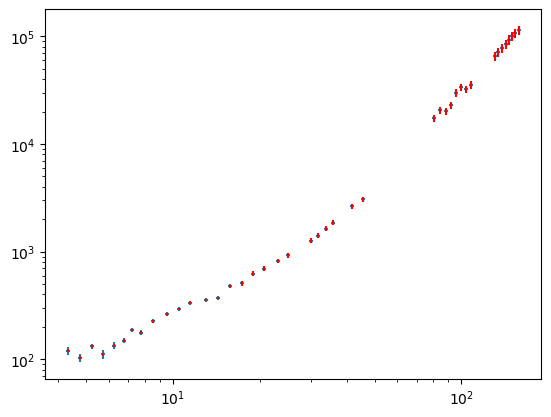

In [78]:
plt.errorbar(mcmc_nu,mcmc_Snu,mcmc_Snu_err,fmt='none')
plt.errorbar(mcmc_nu,mcmc_Snu,flux_scale_errors_scaled,fmt='none',color='red')

plt.scatter(mcmc_nu,mcmc_Snu,s=10,marker='+')

plt.xscale('log')
plt.yscale('log')


In [5]:
## we want to fit the data with maybe two power laws to start, one from contamination and one from true emission

# first we need to decide on parameters

def log_likelihood_two_component(single_contam_theta, v, Sv, Sv_err):

    ## chi = fraction of emission from contamination from brehmstralung
    chi, tot_flux, alpha_dust, alpha_cont, log_f = single_contam_theta 

    # normalize to Ghz
    model = (1-chi)*tot_flux*(v)**alpha_dust + (chi)*tot_flux*(v)**alpha_cont

    sigma2 = Sv_err**2 + model**2 * np.exp(2*log_f)
    # log_model = np.log(model)

    log_likelihood = -0.5 * np.sum((Sv - model) ** 2 / sigma2 + np.log(sigma2))

    return log_likelihood

# Define the prior: flat priors in this example
def log_prior_two_component(single_contam_theta):
    chi, tot_flux, alpha_dust, alpha_cont, log_f = single_contam_theta
    if 0 < chi <= 1 and 0 < tot_flux and 2 < alpha_dust < 6 and -3 < alpha_cont < 3:
        return 0.0  # log(1) = 0 for flat prior
    return -np.inf  # log(0) = -inf for values outside the bounds

# Define the posterior probability function (log-posterior)
def log_posterior_two_component(single_contam_theta, x, y, sigma):
    lp = log_prior_two_component(single_contam_theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_two_component(single_contam_theta, x, y, sigma)


def log_likelihood_three_power_law(single_contam_theta, v, Sv, Sv_err):

    ## chi = fraction of emission from contamination from brehmstralung
    f1, f2, alpha1, alpha2, alpha3, switch, log_f = single_contam_theta 

    f3 = f2 * switch**(alpha2-alpha3)

    # normalize to Ghz
    baseline = f1 * v ** alpha1
    dust = np.where(v < switch, f2 * v ** alpha2, f3 * v ** alpha3)
    model = baseline + dust
    
    sigma2 = Sv_err**2 + model**2 * np.exp(2*log_f)
    # log_model = np.log(model)

    log_likelihood = -0.5 * np.sum((Sv - model) ** 2 / sigma2 + np.log(sigma2))

    return log_likelihood

# Define the prior: flat priors in this example
def log_prior_three_power_law(single_contam_theta):
    f1, f2, alpha1, alpha2, alpha3, switch, log_f = single_contam_theta
    if 0 < f1 < 3000 and 0 < f2 <3000 and -4 < alpha1 < 2 and 2 < alpha2 < 4 and 0 < alpha3 < 4 and 3 < switch < 10:
        return 0.0  # log(1) = 0 for flat prior
    return -np.inf  # log(0) = -inf for values outside the bounds

# Define the posterior probability function (log-posterior)
def log_posterior_three_power_law(single_contam_theta, x, y, sigma):
    lp = log_prior_three_power_law(single_contam_theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_three_power_law(single_contam_theta, x, y, sigma)


def log_likelihood_three_component(single_contam_theta, v, log_Sv, log_Sv_err):

    ## chi = fraction of emission from contamination from brehmstralung
    Fdust, Fbrehm, Fspin, alpha_dust, alpha_brehm, spin_center = single_contam_theta 

    # normalize to Ghz
    model = Fdust*(v)**alpha_dust + Fbrehm*(v)**alpha_brehm + Fspin*(v/spin_center)**2*np.exp((1-(v/spin_center)**2 ))

    log_likelihood = -0.5 * np.sum(((log_Sv - model) / log_Sv_err) ** 2 + np.log(2 * np.pi * log_Sv_err**2))

    return log_likelihood

# Define the prior: flat priors in this example
def log_prior_three_component(single_contam_theta):
    Fdust, Fbrehm, Fspin, alpha_dust, alpha_brehm, spin_center = single_contam_theta
    if  1 < Fdust and 1 < Fbrehm and 1 < Fspin <100  and 0 < alpha_dust < 6 and -10 < alpha_brehm < 10 and 0 < spin_center < 1:
        return 0.0  # log(1) = 0 for flat prior
    return -np.inf  # log(0) = -inf for values outside the bounds

# Define the posterior probability function (log-posterior)
def log_posterior_three_component(single_contam_theta, x, y, sigma):
    lp = log_prior_three_component(single_contam_theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_three_component(single_contam_theta, x, y, sigma)


In [198]:

def check_convergence(sampler, threshold=50, discard=100):
    try:
        # Estimate the autocorrelation time
        autocorr_time = sampler.get_autocorr_time(tol=0)

        print(autocorr_time)
        
        # Check if the chain length is sufficiently larger than the autocorrelation time
        converged = sampler.chain.shape[1] > threshold * np.max(autocorr_time)

        return converged, autocorr_time
    except emcee.autocorr.AutocorrError:
        # AutocorrError is raised if chain length is too short to estimate autocorrelation time
        print("Chain is too short to reliably estimate autocorrelation time.")
        return False, None



## plotting MCMC chains
def plot_chains(sampler,labels,ndim):

    chains_fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.axvline(x=.15*len(samples[:, :, i]),color='red',ls='--',alpha=.6)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.show()

    return chains_fig

## set up MCMC sampler
def run_mcmc(ndim, nu, Snu, Snu_err,nsteps=20000,walkers_scaling=10,scaling=33, burn_fraction=.15,plot=False):

    # Set up the MCMC sampler
    nwalkers = ndim*walkers_scaling  # number of walkers

    # Initialize walkers close to plausible values
    if ndim == 5:
        labels = ['chi','Ftot','alpha dust','alpha cont','log_f']
        initial_guess = np.array([.5, 1000, 2,1,100])  # initial guesses for two component model

    if ndim ==7:
        labels = [r'$S_v^{cont}$',r'$S_v^{dust1}$',r'$\alpha_{cont}$',r'$\alpha_{dust1}$',r'$\alpha_{dust2}$',r'$v_{\rm switch}$','log_f']
        initial_guess = np.array([1000,300,1,3,2,7, 10]) # Fdust, Fbrehm, Fspin, alpha_dust, alpha_brehm, spin_center GHz
    
    # if ndim ==6:
    #     labels = [r'$S_v^{dust}$',r'$S_v^{brehm}$',r'$F_v^{spin}$',r'$\alpha_{dust}$',r'$\alpha_{brehm}$',r'$\nu_{spin}$']
    #     initial_guess = np.array([800,800,30,4,1,.3]) # Fdust, Fbrehm, Fspin, alpha_dust, alpha_brehm, spin_center GHz

    initial_position = initial_guess + 0.1 * np.random.randn(nwalkers, ndim) * initial_guess

    # log data
    log_Snu_vis = np.log(Snu)
    log_err_Snu_vis = np.log(Snu_err)

    # normalize Nu Vis to Ghz
    norm_nu_vis = nu / (scaling)

    # Set up the emcee sampler
    if ndim == 5:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_two_component, args=(norm_nu_vis, Snu, Snu_err),a=2.5)
    if ndim == 7:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_three_power_law, args=(norm_nu_vis, Snu, Snu_err))

    # if ndim == 6:
    #     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_three_component, args=(norm_nu_vis, Snu, Snu_err))


    # Run the MCMC
    sampler.run_mcmc(initial_position, int(nsteps/2), progress=True)
    # tau = sampler.get_autocorr_time()

    # print('autocorr time', tau)
    # Extract the samples
    samples = sampler.chain


    # filter out problematic walkers

    # Step 1: Calculate the overall mean of each parameter across all walkers and steps
    overall_mean = np.mean(samples, axis=(0, 1))  # Shape should be (n_dim,)

    # Step 2: Calculate the mean for each walker (average over n_steps for each walker)
    walker_means = np.mean(samples, axis=1)  # Shape should be (n_walkers, n_dim)

    # Step 3: Calculate the distance of each walker mean from the overall mean
    deviations = np.linalg.norm(walker_means - overall_mean, axis=1)
    # Step 4: Identify outlier walkers (e.g., threshold as 2 standard deviations from the mean deviation)
    threshold = 2 * np.std(deviations)

    outliers = deviations > threshold

    # Step 5: Filter out outlier walkers and set up new initial positions
    filtered_walkers = walker_means[~outliers]  # Keeps only non-outlier walkers

    # Step 6: Restart the emcee sampler with the filtered walkers as the new starting positions
    nwalkers_filtered, ndim = filtered_walkers.shape

    sampler = emcee.EnsembleSampler(int(np.round(nwalkers/2)), ndim, log_posterior_two_component, args=(norm_nu_vis, Snu, Snu_err),a=2.5)

    sampler.run_mcmc(filtered_walkers[:int(np.round(nwalkers/2))], nsteps, progress=True)

    samples = sampler.get_chain(thin=15, flat=True)


    params = []
    # burn 1500
    for i in range(ndim):
        params.append(np.median(samples[int(np.round(len(samples)*burn_fraction)):, i]))

    # chi_emcee = np.mean(chi_emcee_samples)
    # tot_flux_emcee = np.mean(tot_flux_emcee_samples)
    # alpha_dust_emcee = np.mean(alpha_dust_emcee_samples)
    # alpha_cont_emcee = np.mean(alpha_cont_emcee_samples)



    samples = samples[int(np.round(len(samples)*burn_fraction)):, :]


    if plot:

        chains_fig = plot_chains(sampler,labels,ndim)
    # Assuming `samples` is your MCMC chain samples (shape: nsteps, nwalkers, ndim)
        flat_samples = samples.reshape((-1, ndim))  # Flatten if using an MCMC sampler like emcee
        corner_labels = ["$\\chi$", "$S_{cm}$", "$\\alpha^d$", "$\\alpha^c$"] if ndim == 4 else labels
        corner_fig = corner.corner(flat_samples, labels=corner_labels, show_titles=True)
        corner_fig.show()

        return samples, sampler, params, norm_nu_vis, labels, chains_fig, corner_fig

    else:
        return samples, sampler, params, norm_nu_vis, labels

In [199]:

# convert to GHz

ndim = 7
scaling = 33

model_type = 'three power law'
if ndim == 5:
    model_type = 'two power law'

samples, sampler, params, norm_nu_vis, labels, chains_fig, corner_fig = run_mcmc(ndim, mcmc_nu,mcmc_Snu,mcmc_Snu_err,10000,15,scaling)

 31%|███       | 1553/5000 [00:02<00:05, 631.87it/s]Traceback (most recent call last):
  File "/opt/miniconda3/envs/disker/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/vy/3w_cyymn26g4jzqfnt1dv5xm0000gn/T/ipykernel_44544/765782195.py", line 64, in log_posterior_three_power_law
    if not np.isfinite(lp):
           ^^^^^^^^^^^^^^^
KeyboardInterrupt
 31%|███       | 1553/5000 [00:02<00:05, 620.63it/s]

emcee: Exception while calling your likelihood function:
  params: [1177.07509644  302.61662597    1.2612335     3.89311342    3.37180719
    2.30540029   -2.56458478]
  args: (array([0.13087314, 0.14389364, 0.15929928, 0.17301219, 0.18890854,
       0.2046063 , 0.2195579 , 0.2347579 , 0.25796279, 0.28809088,
       0.31795997, 0.34650576, 0.39471255, 0.43517764, 0.47991394,
       0.52479518, 0.57538207, 0.62629965, 0.70051941, 0.7588595 ,
       0.90946353, 0.96611427, 1.02910067, 1.08920599, 1.26667942,
       1.3830404 , 2.4310425 , 2.55414804, 2.67346596, 2.7965726 ,
       2.90043163, 3.02353717, 3.14285928, 3.26596592, 3.94627104,
       4.06935689, 4.18867986, 4.31178568, 4.41558508, 4.53867093,
       4.65807007, 4.78117589]), array([1.19580496e+02, 1.02963795e+02, 1.31775781e+02, 1.10764325e+02,
       1.33862488e+02, 1.49271242e+02, 1.86980312e+02, 1.76945359e+02,
       2.24872952e+02, 2.62294670e+02, 2.92929944e+02, 3.34472180e+02,
       3.55798309e+02, 3.70428785e+02, 4.

KeyboardInterrupt: 

In [206]:
def plot_mcmc_results(ndim, scaling, samples, params, norm_nu_vis, labels):

    nu_model = np.linspace(np.min(norm_nu_vis), np.max(norm_nu_vis),1000)
    # nu_model = norm_nu_vis

    plotting_fig, axs = plt.subplots(2,1,figsize=(15,20))

    if ndim == 5:

        chi, tot_flux, alpha_dust, alpha_cont, log_f = tuple(params)
        # chi, tot_flux, alpha_dust, alpha_cont =0.18130303539575973, 1772.2775570866784, 2.6438262226287677, 0.5

        print('4 free parameter fit')
        print('mcmc params',(chi, tot_flux, alpha_dust, alpha_cont))
        dust_Sv = (1-chi)*tot_flux*(nu_model)**alpha_dust
        cont_Sv = (chi)*tot_flux*(nu_model)**alpha_cont
        model_Sv = dust_Sv + cont_Sv
        likelihood_model_Sv = (1-chi)*tot_flux*(norm_nu_vis)**alpha_dust + (chi)*tot_flux*(norm_nu_vis)**alpha_cont

        nu_model = nu_model * scaling
        axs[0].plot(nu_model, model_Sv,color='purple',label='contamination + emission')
        axs[0].plot(nu_model, dust_Sv,color='blue',ls='--',label='dust emission')
        axs[0].plot(nu_model, cont_Sv,color='red',ls='--', label='contamination')

        text = (
            r"$\chi$= " + f'{np.round(chi,2)}\n' + 
            r'$S_{cm}=$' + f'{int(np.round(tot_flux))}\n' + 
            r'$\alpha^{d}=$' + f'{np.round(alpha_dust,2)}\n' + 
            r'$\alpha^{c}=$' + f'{np.round(alpha_cont,2)}\n'
        )





    if ndim == 7:
        # Fdust, Fbrehm, Fspin, alpha_dust, alpha_brehm, spin_center = tuple(params)
        # dust_Sv = Fdust*(nu_model)**alpha_dust
        # cont_Sv = Fbrehm*(nu_model)**alpha_brehm 
        # spin_Sv =  Fspin*(nu_model/spin_center)**2*np.exp((1-(nu_model/spin_center)**2 ))

        # plt.plot(nu_model, model_Sv,color='purple',label='contamination + thermal emission')
        # plt.plot(nu_model, dust_Sv,color='blue',ls='--',label='dust emission')
        # plt.plot(nu_model, cont_Sv,color='red',ls='--',label='bremsstrahlung')
        # plt.plot(nu_model, spin_Sv,color='orange',ls='--',label='spinning dust')


        # model_Sv = dust_Sv+ cont_Sv+ spin_Sv
        # likelihood_model_Sv = Fdust*(norm_nu_vis)**alpha_dust + Fbrehm*(norm_nu_vis)**alpha_brehm + Fspin*(norm_nu_vis/spin_center)**2*np.exp((1-(norm_nu_vis/spin_center)**2 ))

        # new_params = 718.9141422460193, 997.3014833275594, 3870.7791572388887, 0.9344492280508075, 2.9204043820409122, 2.225422481520467, 6.37048905153356, -3.0079619362793024
        f1, f2, a1, a2, a3, switch, log_f = tuple(params)

        
        f3 = f2 * switch**(a2-a3)

        cont_Sv = f1 * nu_model ** a1
        dust_Sv = np.where(nu_model < switch, f2 * nu_model ** a2, f3 * nu_model ** a3)
        model_Sv = cont_Sv + dust_Sv



        axs[0].plot(nu_model, model_Sv,color='purple',label='contamination + thermal emission')
        axs[0].plot(nu_model, dust_Sv,color='blue',ls='--',label='dust emission')
        axs[0].plot(nu_model, cont_Sv,color='red',ls='--',label='contamination')


        likelihood_cont_Sv = f1 * norm_nu_vis ** a1
        likelihood_dust_Sv = np.where(norm_nu_vis < switch, f2 * norm_nu_vis ** a2, f3 * norm_nu_vis ** a3)
        likelihood_model_Sv = likelihood_cont_Sv + likelihood_dust_Sv



        text = ""
        for i in range(ndim):
            if i < 2:
                text+= labels[i] + f'= {int(np.round(params[i]))}\n'
            if 1 < i < ndim-1:
                text+= labels[i] + f'= {np.round(params[i],2)}\n'
            if i == ndim-1:
                text+= labels[i] + f'= {np.round(params[i],2)}'


        print('mcmc params',params)



    flat_samples = samples.reshape((-1, ndim))  # Flatten the samples

    # Labels for the corner plot
    corner_labels = ["$\\chi$", "$S_{cm}$", "$\\alpha^d$", "$\\alpha^c$"] if ndim == 4 else labels



    axs[0].legend(loc='upper left')
    axs[0].set_xlabel(f"Freq [GHz]")
    axs[0].set_ylabel(r"micro Jy")

    axs[0].scatter(mcmc_nu, mcmc_Snu,color='black',s=20, marker='s')
    axs[0].errorbar(mcmc_nu,mcmc_Snu, mcmc_Snu_err, color='black',fmt='none')

    axs[0].set_xscale('log'); axs[0].set_yscale('log')
    axs[0].set_ylim(60,10**7)

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)  # Customize the appearance
    axs[0].text(1.04, 2.17, text, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    axs[0].grid(alpha=.3,which='both',ls='--')


    ## residuals plot
    residuals = (mcmc_Snu - likelihood_model_Sv) / mcmc_Snu_err
    axs[1].scatter(mcmc_nu , residuals, color='black', s=20)
    axs[1].axhline(0, color='black', ls='--', lw=1)
    axs[1].set_xlabel(f"Freq [GHz]")
    axs[1].set_ylabel(r"Residuals (Normalized)")
    axs[1].set_xscale('log')
    axs[1].set_yscale('linear')
    axs[1].grid(alpha=.3,which='both',ls='--')


    loggy_likelihood = -0.5 * np.sum(((mcmc_Snu - likelihood_model_Sv) / mcmc_Snu_err) ** 2 + np.log(2 * np.pi * mcmc_Snu_err**2))
    print('Log Likelihood',loggy_likelihood)


    chi2 = np.sum((mcmc_Snu - likelihood_model_Sv) ** 2 / mcmc_Snu_err ** 2)
    print('chi2', chi2)

In [197]:
## run boostrap stuff

## code to bootstrap data

def bootstrap_data(mcmc_nu, mcmc_Snu,errors_scaled,num_bootstraps,error_override=1):

    # override bootstrapping if desired
    errors_scaled = errors_scaled * error_override
    
    bootstrapped_data = np.array([
    [np.random.normal(loc=point, scale=error) for point, error in zip(mcmc_Snu, errors_scaled)]
    for _ in range(num_bootstraps)
    ])

    return bootstrapped_data, errors_scaled


def boot_wrapper(data_version,mcmc_nu,mcmc_Snu,mcmc_Snu_err,errors_scaled,ndim,n_bootstrap=1000,nsteps=10000,plot=False, error_override=1):
    all_bootstrapped_data, scaled_errors = bootstrap_data(mcmc_nu,mcmc_Snu,errors_scaled,n_bootstrap,error_override)


    for b_data in all_bootstrapped_data:
        plt.scatter(mcmc_nu,b_data,s=1)
    plt.xscale('log')
    plt.yscale('log')

    plt.show()

    all_samples = []

    scaling = 33
    burn_fraction = .3
    for b_data in all_bootstrapped_data:
        if plot:
            samples, sampler, params, norm_nu_vis, labels,chains_fig, corner_fig = run_mcmc(ndim, mcmc_nu,b_data,mcmc_Snu_err,nsteps,15,scaling,burn_fraction=burn_fraction,plot=plot)
        else:
            samples, sampler, params, norm_nu_vis, labels = run_mcmc(ndim, mcmc_nu,b_data,mcmc_Snu_err,nsteps,15,scaling,burn_fraction=burn_fraction,plot=plot)

        # Example usage  after running MCMC
        converged, autocorr_time = check_convergence(sampler,threshold=5)
        if converged:
            print('converged!')
            all_samples.append(samples)

        if plot == True:
            plot_mcmc_results(ndim, scaling, samples, params, norm_nu_vis, labels)

    all_samples = np.array(all_samples)

    flat_all_samples = all_samples.reshape((-1, ndim))  # Flatten if using an MCMC sampler like emcee


    # if plot:
    #     corner_labels = labels
    #     corner_fig = corner.corner(flat_all_samples, labels=corner_labels, show_titles=True)
    #     corner_fig.show()

    return flat_all_samples, labels


In [194]:
def data_version_wrapper(data_type,archive_bool,n_bootstrap,ndim,plot=False):

    all_data_versions = []
    all_data_samples_outputs = []
    colors= ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
    
    if data_type == 'all':
        data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version('img',archive_bool,0,4)
        combined_b_samples1,labels = boot_wrapper(data_version,mcmc_nu,mcmc_Snu,mcmc_Snu_err,flux_scale_errors_scaled,ndim,n_bootstrap=n_bootstrap,plot=plot,error_override=1)
        all_data_versions.append('img 0')
        all_data_samples_outputs.append(combined_b_samples1)
        print(f'{all_data_versions[-1]} done!')



        data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version('img',archive_bool,3,4)
        combined_b_samples2,labels = boot_wrapper(data_version,mcmc_nu,mcmc_Snu,mcmc_Snu_err,flux_scale_errors_scaled,ndim,n_bootstrap=n_bootstrap,plot=plot)
        all_data_versions.append('img -- 3')
        all_data_samples_outputs.append(combined_b_samples2)
        print(f'{all_data_versions[-1]} done!')


        data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version('img',archive_bool,4,4)
        combined_b_samples3,labels = boot_wrapper(data_version,mcmc_nu,mcmc_Snu,mcmc_Snu_err,flux_scale_errors_scaled,ndim,n_bootstrap=n_bootstrap,plot=plot)
        all_data_versions.append('img -- 4')
        all_data_samples_outputs.append(combined_b_samples3)
        print(f'{all_data_versions[-1]} done!')


        data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version('img',archive_bool,5,4)
        combined_b_samples4,labels = boot_wrapper(data_version,mcmc_nu,mcmc_Snu,mcmc_Snu_err,flux_scale_errors_scaled,ndim,n_bootstrap=n_bootstrap,plot=plot)
        all_data_versions.append('img -- 5')
        all_data_samples_outputs.append(combined_b_samples4)
        print(f'{all_data_versions[-1]} done!')


        data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version('vis',archive_bool,0,4)
        combined_b_samples5,labels = boot_wrapper(data_version,mcmc_nu,mcmc_Snu,mcmc_Snu_err,flux_scale_errors_scaled,ndim,n_bootstrap=n_bootstrap,plot=plot)
        all_data_versions.append('vis -- 0')
        all_data_samples_outputs.append(combined_b_samples5)
        print(f'{all_data_versions[-1]} done!')

    else:
        data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version(data_type,archive_bool,0,4)
        combined_b_samples1,labels = boot_wrapper(data_version,mcmc_nu,mcmc_Snu,mcmc_Snu_err,flux_scale_errors_scaled,ndim, n_bootstrap=n_bootstrap,plot=plot,error_override=1)
        all_data_versions.append(data_type+'bootstrap')
        all_data_samples_outputs.append(combined_b_samples1)
        print(f'{all_data_versions[-1]} done!')

        data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version(data_type,archive_bool,0,4)
        combined_b_samples1,labels = boot_wrapper(data_version,mcmc_nu,mcmc_Snu,mcmc_Snu_err,flux_scale_errors_scaled,ndim, n_bootstrap=n_bootstrap,plot=plot,error_override=0)
        all_data_versions.append(data_type+'no bootstrap')
        all_data_samples_outputs.append(combined_b_samples1)
        print(f'{all_data_versions[-1]} done!')


    fig, axs = plt.subplots(ndim,1,figsize=(20,30))
    plt.subplots_adjust(hspace=.5)

    print([len(x) for x in all_data_samples_outputs])
    


    for version_num in range(len(all_data_samples_outputs)):
        flat_all_samples = all_data_samples_outputs[version_num]
        for num in range(len(labels)):
            data = [x[num] for x in flat_all_samples]
            print(len(data))
            kde = gaussian_kde(data)
            x_vals = np.linspace(min(data), max(data), 1000)
            kde_vals = kde(x_vals)
            # Plot the KDE
            axs[num].plot(x_vals, kde_vals, color=colors[version_num],zorder=2,label=all_data_versions[version_num])
            axs[num].fill_between(x_vals, kde_vals, color=colors[version_num], alpha=0.4,zorder=2)
            axs[num].set_ylabel('Density',fontsize=12)
            axs[num].set_xlabel('Value',fontsize=12)


            axs[num].minorticks_on()

            # Customize major and minor ticks
            axs[num].tick_params(axis='both', which='major', length=7, width=1.5, color='black')
            axs[num].tick_params(axis='both', which='minor', length=4, width=1, color='gray')

            axs[num].grid(alpha=.4,ls='--',zorder=0,which='both')
            axs[num].tick_params(axis='both',labelsize=12)



            axs[num].set_title(labels[num],fontsize=20)
            axs[num].legend(fontsize=10)

            
            # axs[num].set_ylim(0,axs[num].get_ylim()[1]*1.5)

    plt.legend()
    plt.show()

[2997.92458    2141.3747     1873.7028625   676.73241084  347.38407648
  340.67324773  267.1947041   230.60958308  217.87242587  214.13747
  115.30479154  111.0342437   107.068735  ]


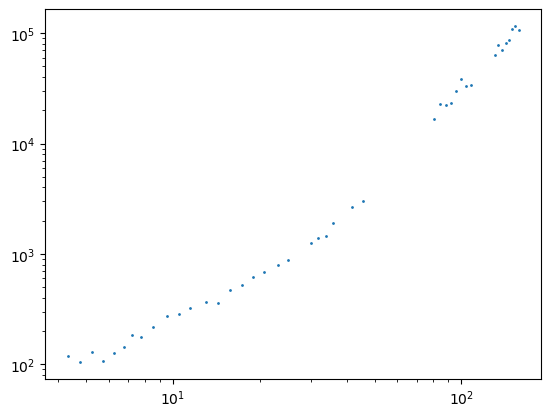

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/miniconda3/envs/disker/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:06<00:00, 1523.19it/s]


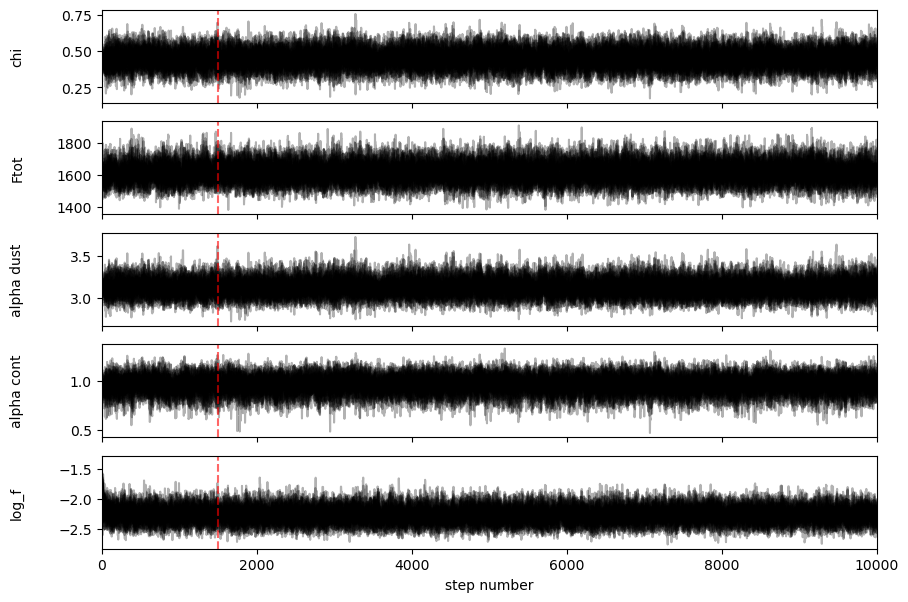

/var/folders/vy/3w_cyymn26g4jzqfnt1dv5xm0000gn/T/ipykernel_44544/3572556689.py:134: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  corner_fig.show()


[62.0613729  57.29026145 61.24576515 62.90787051 54.68516642]
converged!
4 free parameter fit
mcmc params (0.44871545701495963, 1615.224040689495, 3.1243318252318053, 0.9666639515183095)
Log Likelihood -1623.7364813301824
chi2 2853.4905673996545
visbootstrap done!
[2997.92458    2141.3747     1873.7028625   676.73241084  347.38407648
  340.67324773  267.1947041   230.60958308  217.87242587  214.13747
  115.30479154  111.0342437   107.068735  ]


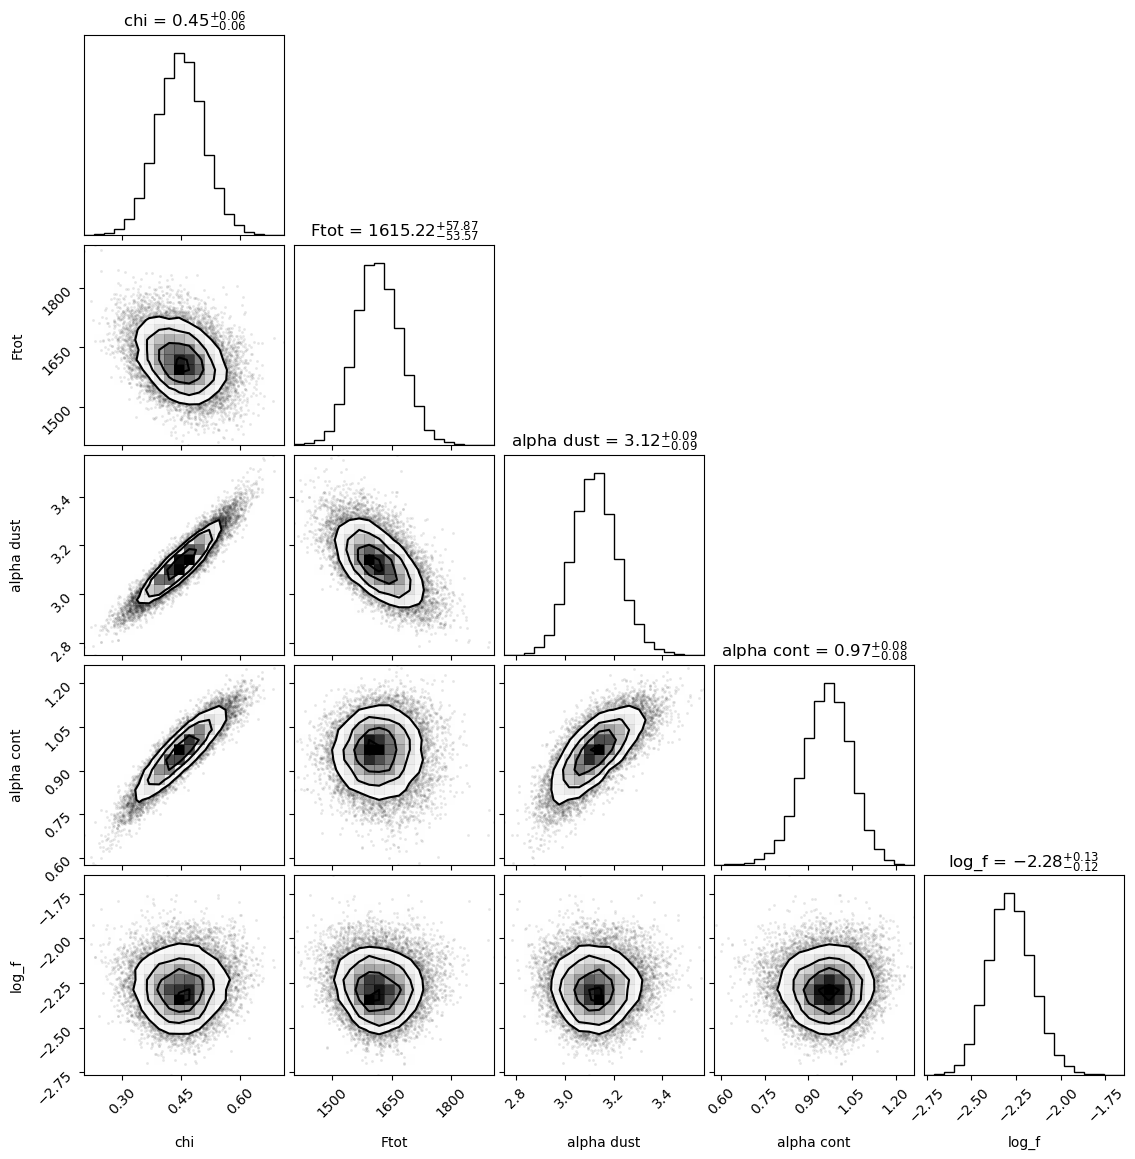

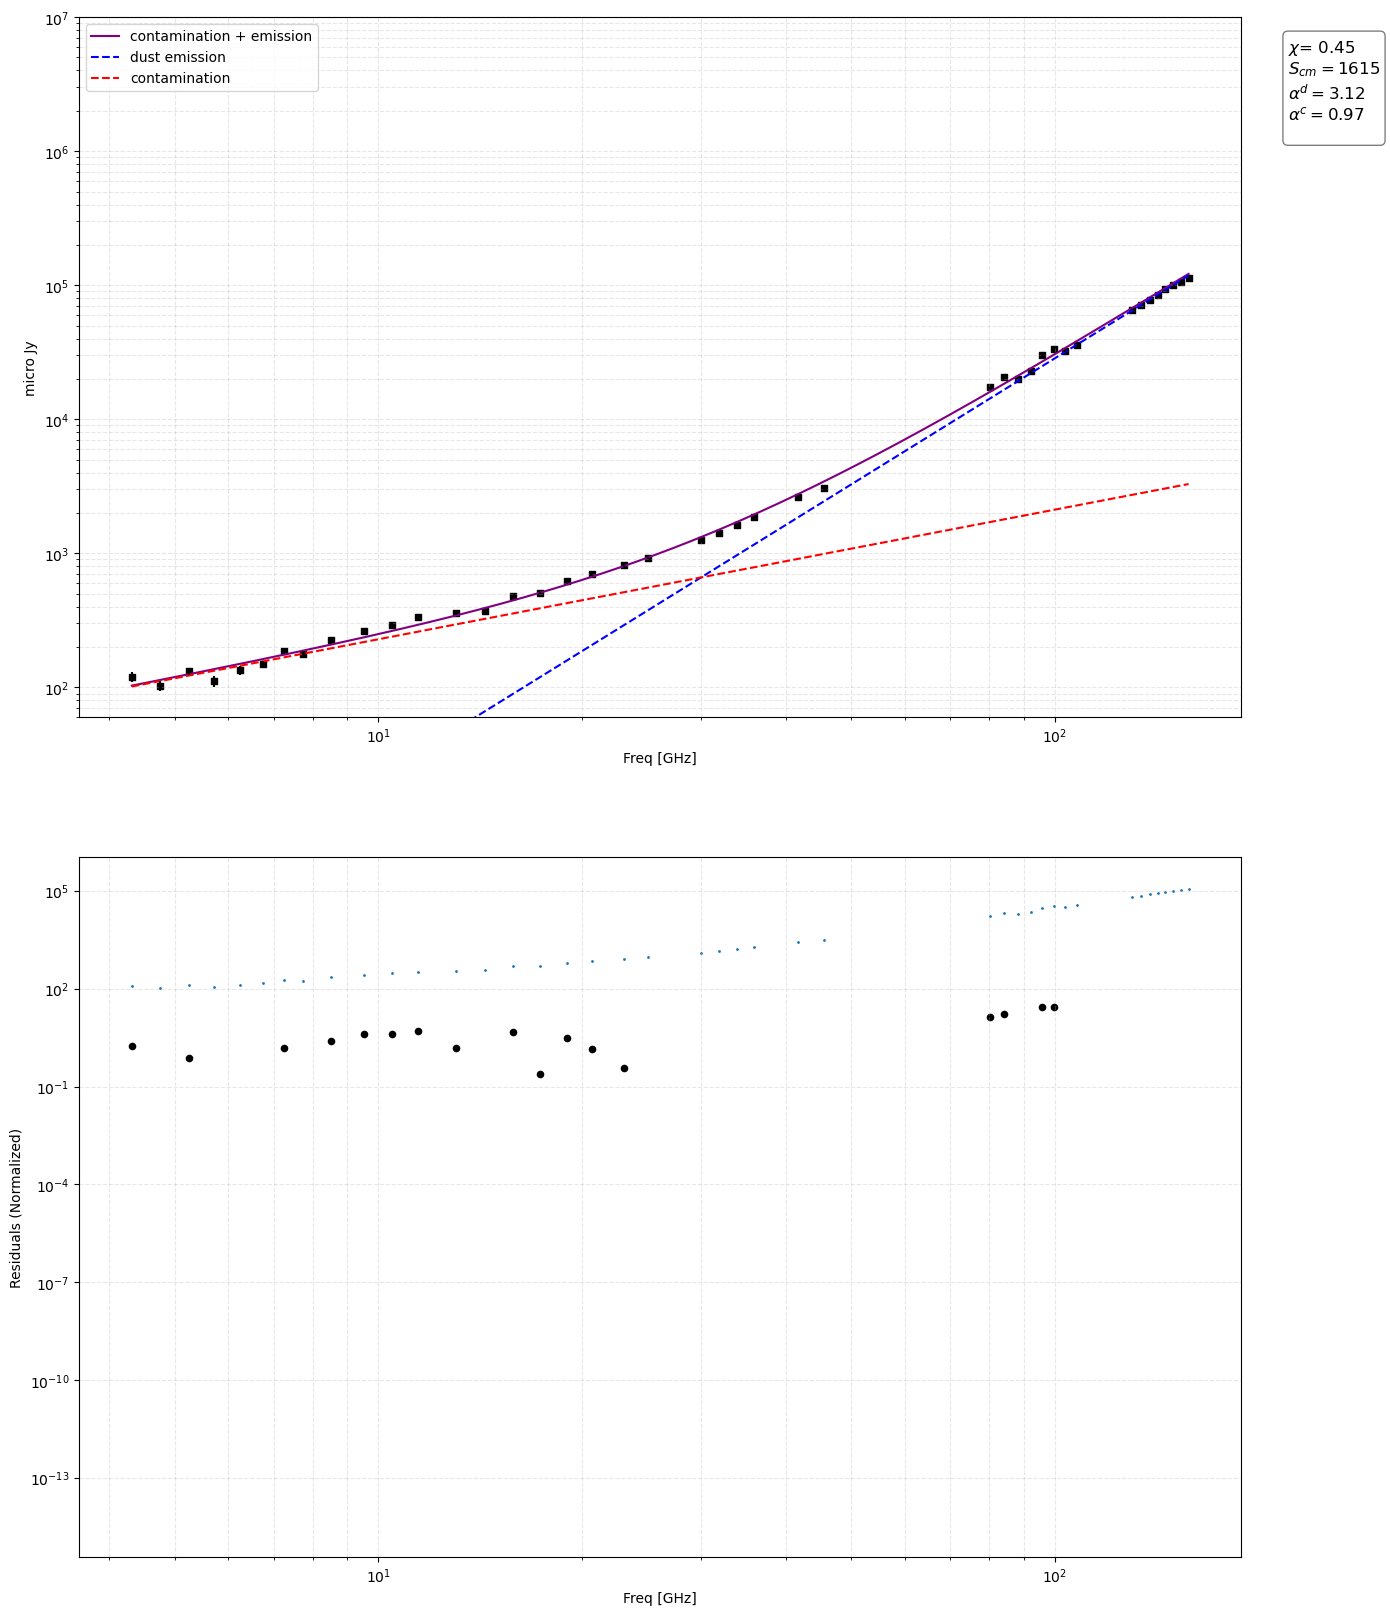

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/miniconda3/envs/disker/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:06<00:00, 1617.23it/s]


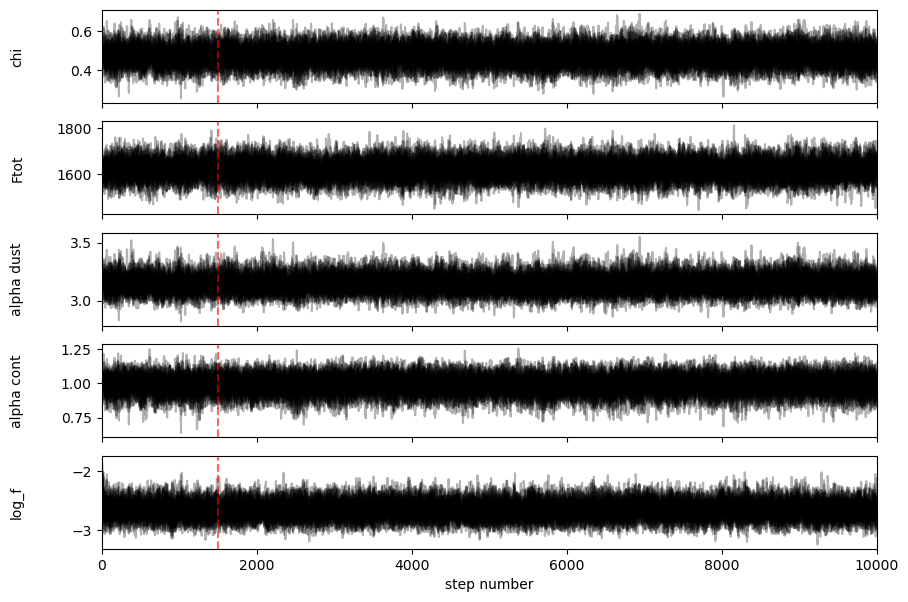

/var/folders/vy/3w_cyymn26g4jzqfnt1dv5xm0000gn/T/ipykernel_44544/3572556689.py:134: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  corner_fig.show()


[63.89546012 54.70912859 63.5317645  62.57804842 57.31062788]
converged!
4 free parameter fit
mcmc params (0.47531875910260224, 1616.0419730756903, 3.144486601933739, 0.9901116983383169)
Log Likelihood -1752.1700794277358
chi2 3110.3577635947613
visno bootstrap done!
[17716, 17716]
17716
17716
17716
17716
17716
17716
17716
17716
17716
17716


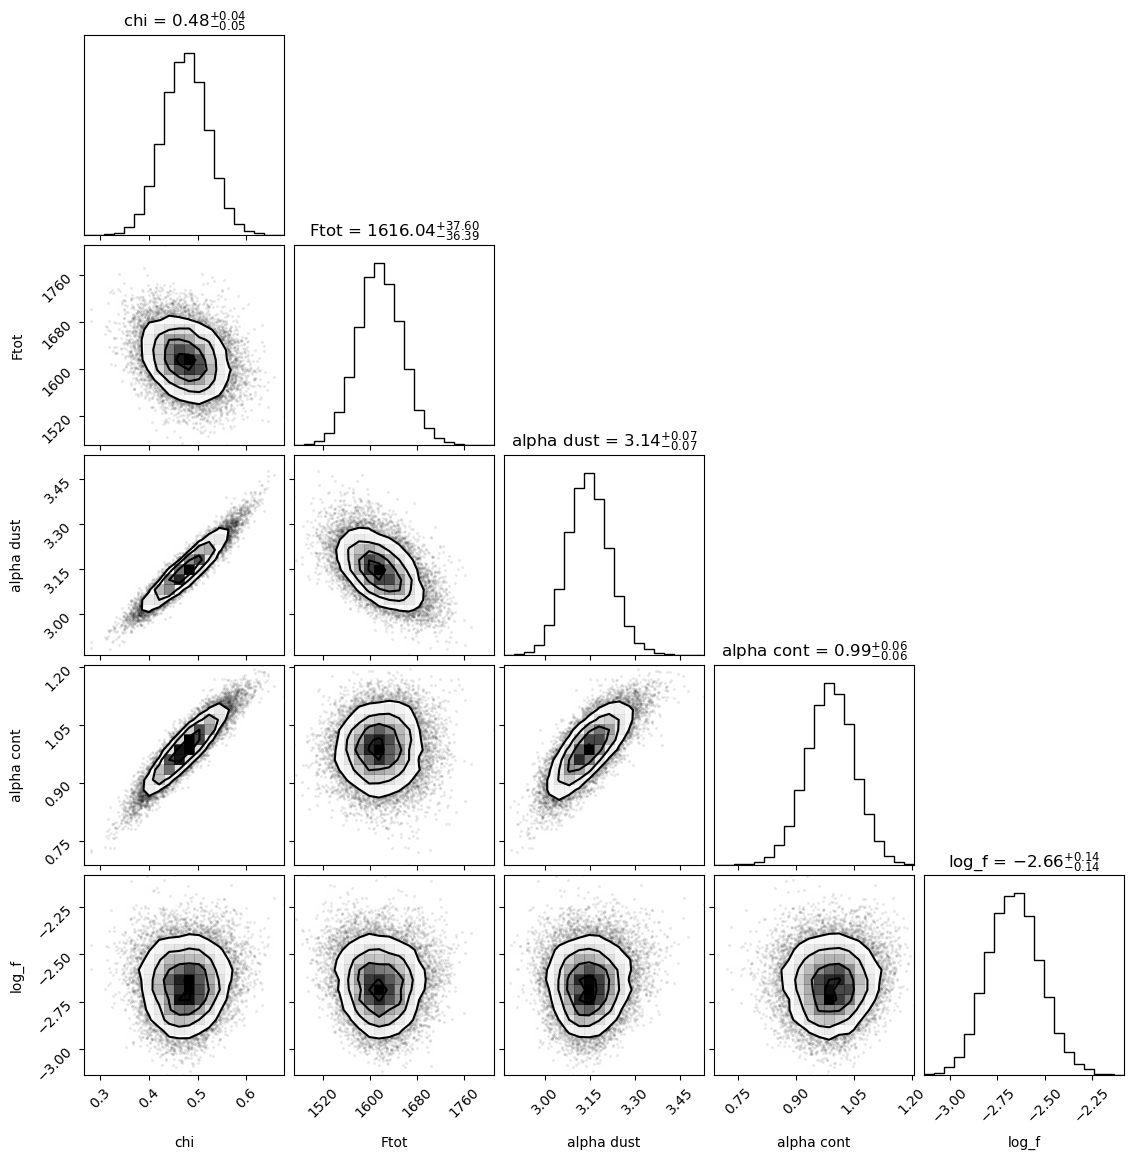

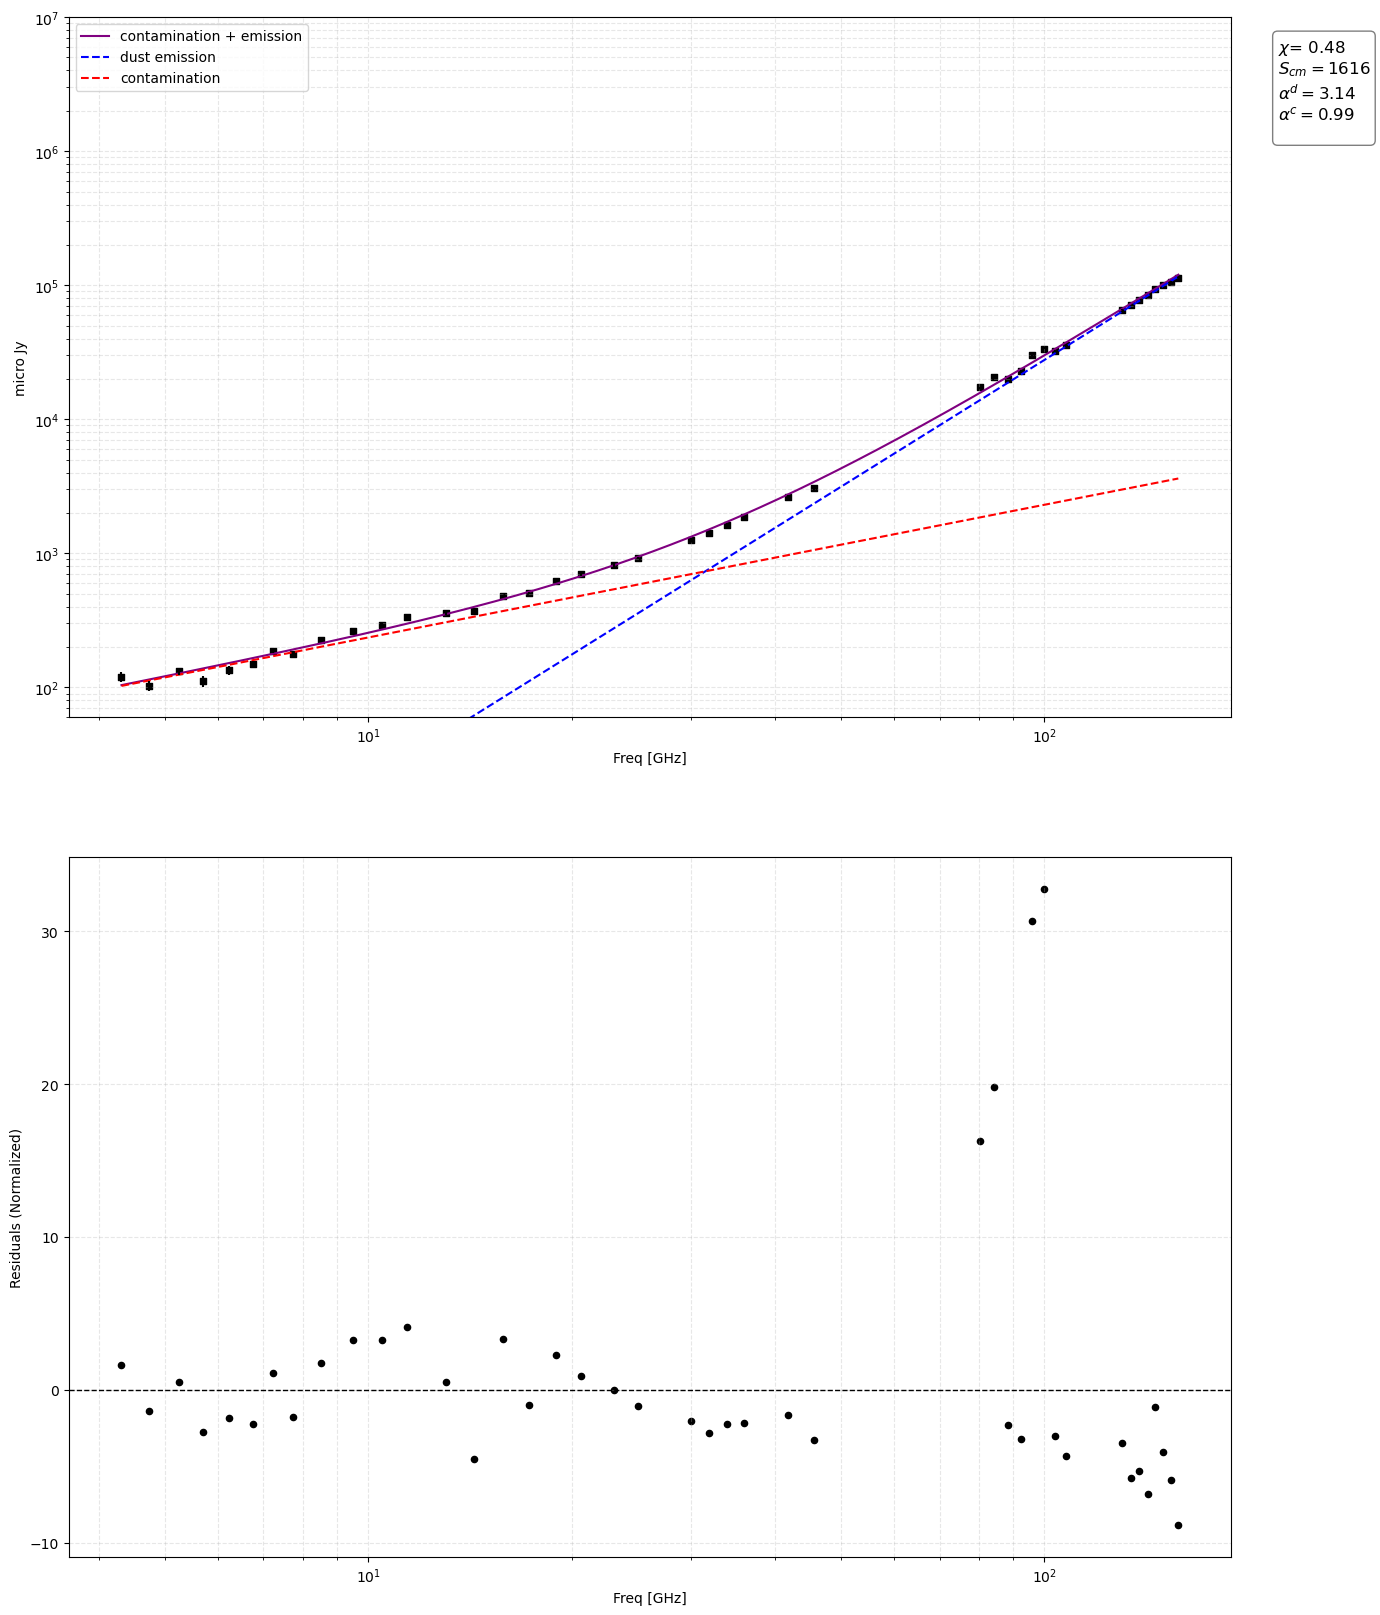

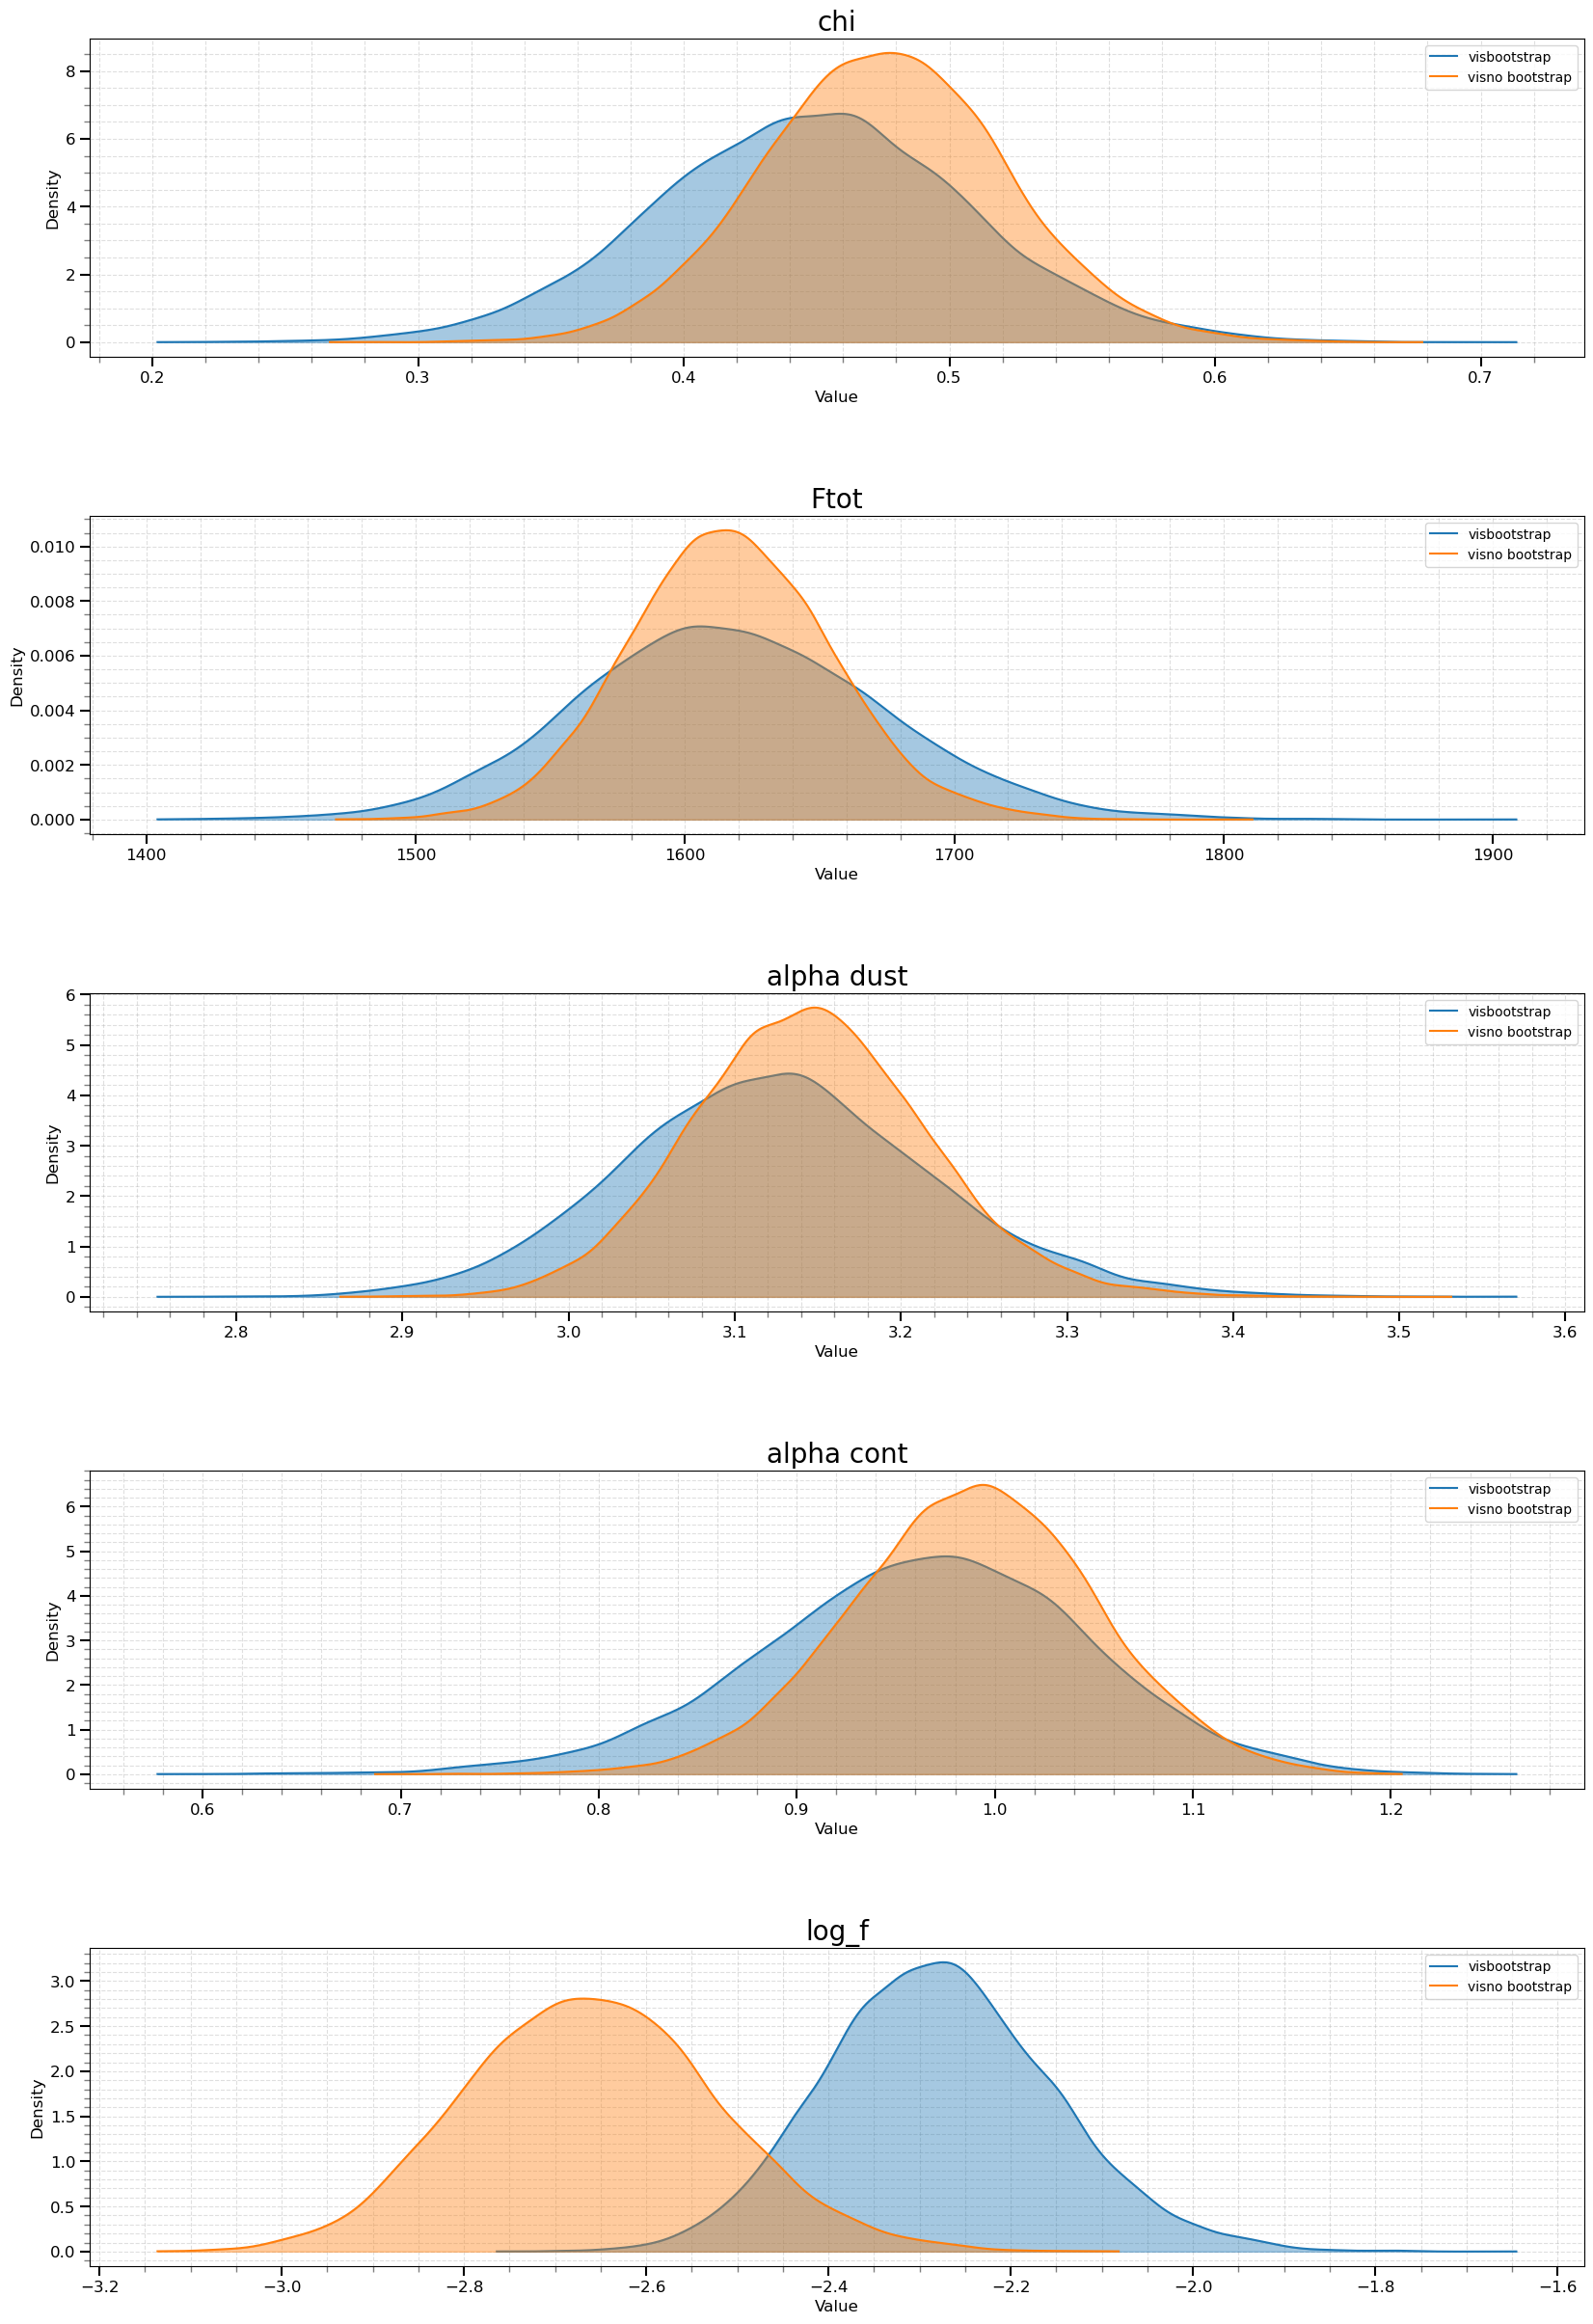

In [207]:
data_version_wrapper('vis',False,1,5,plot=True)

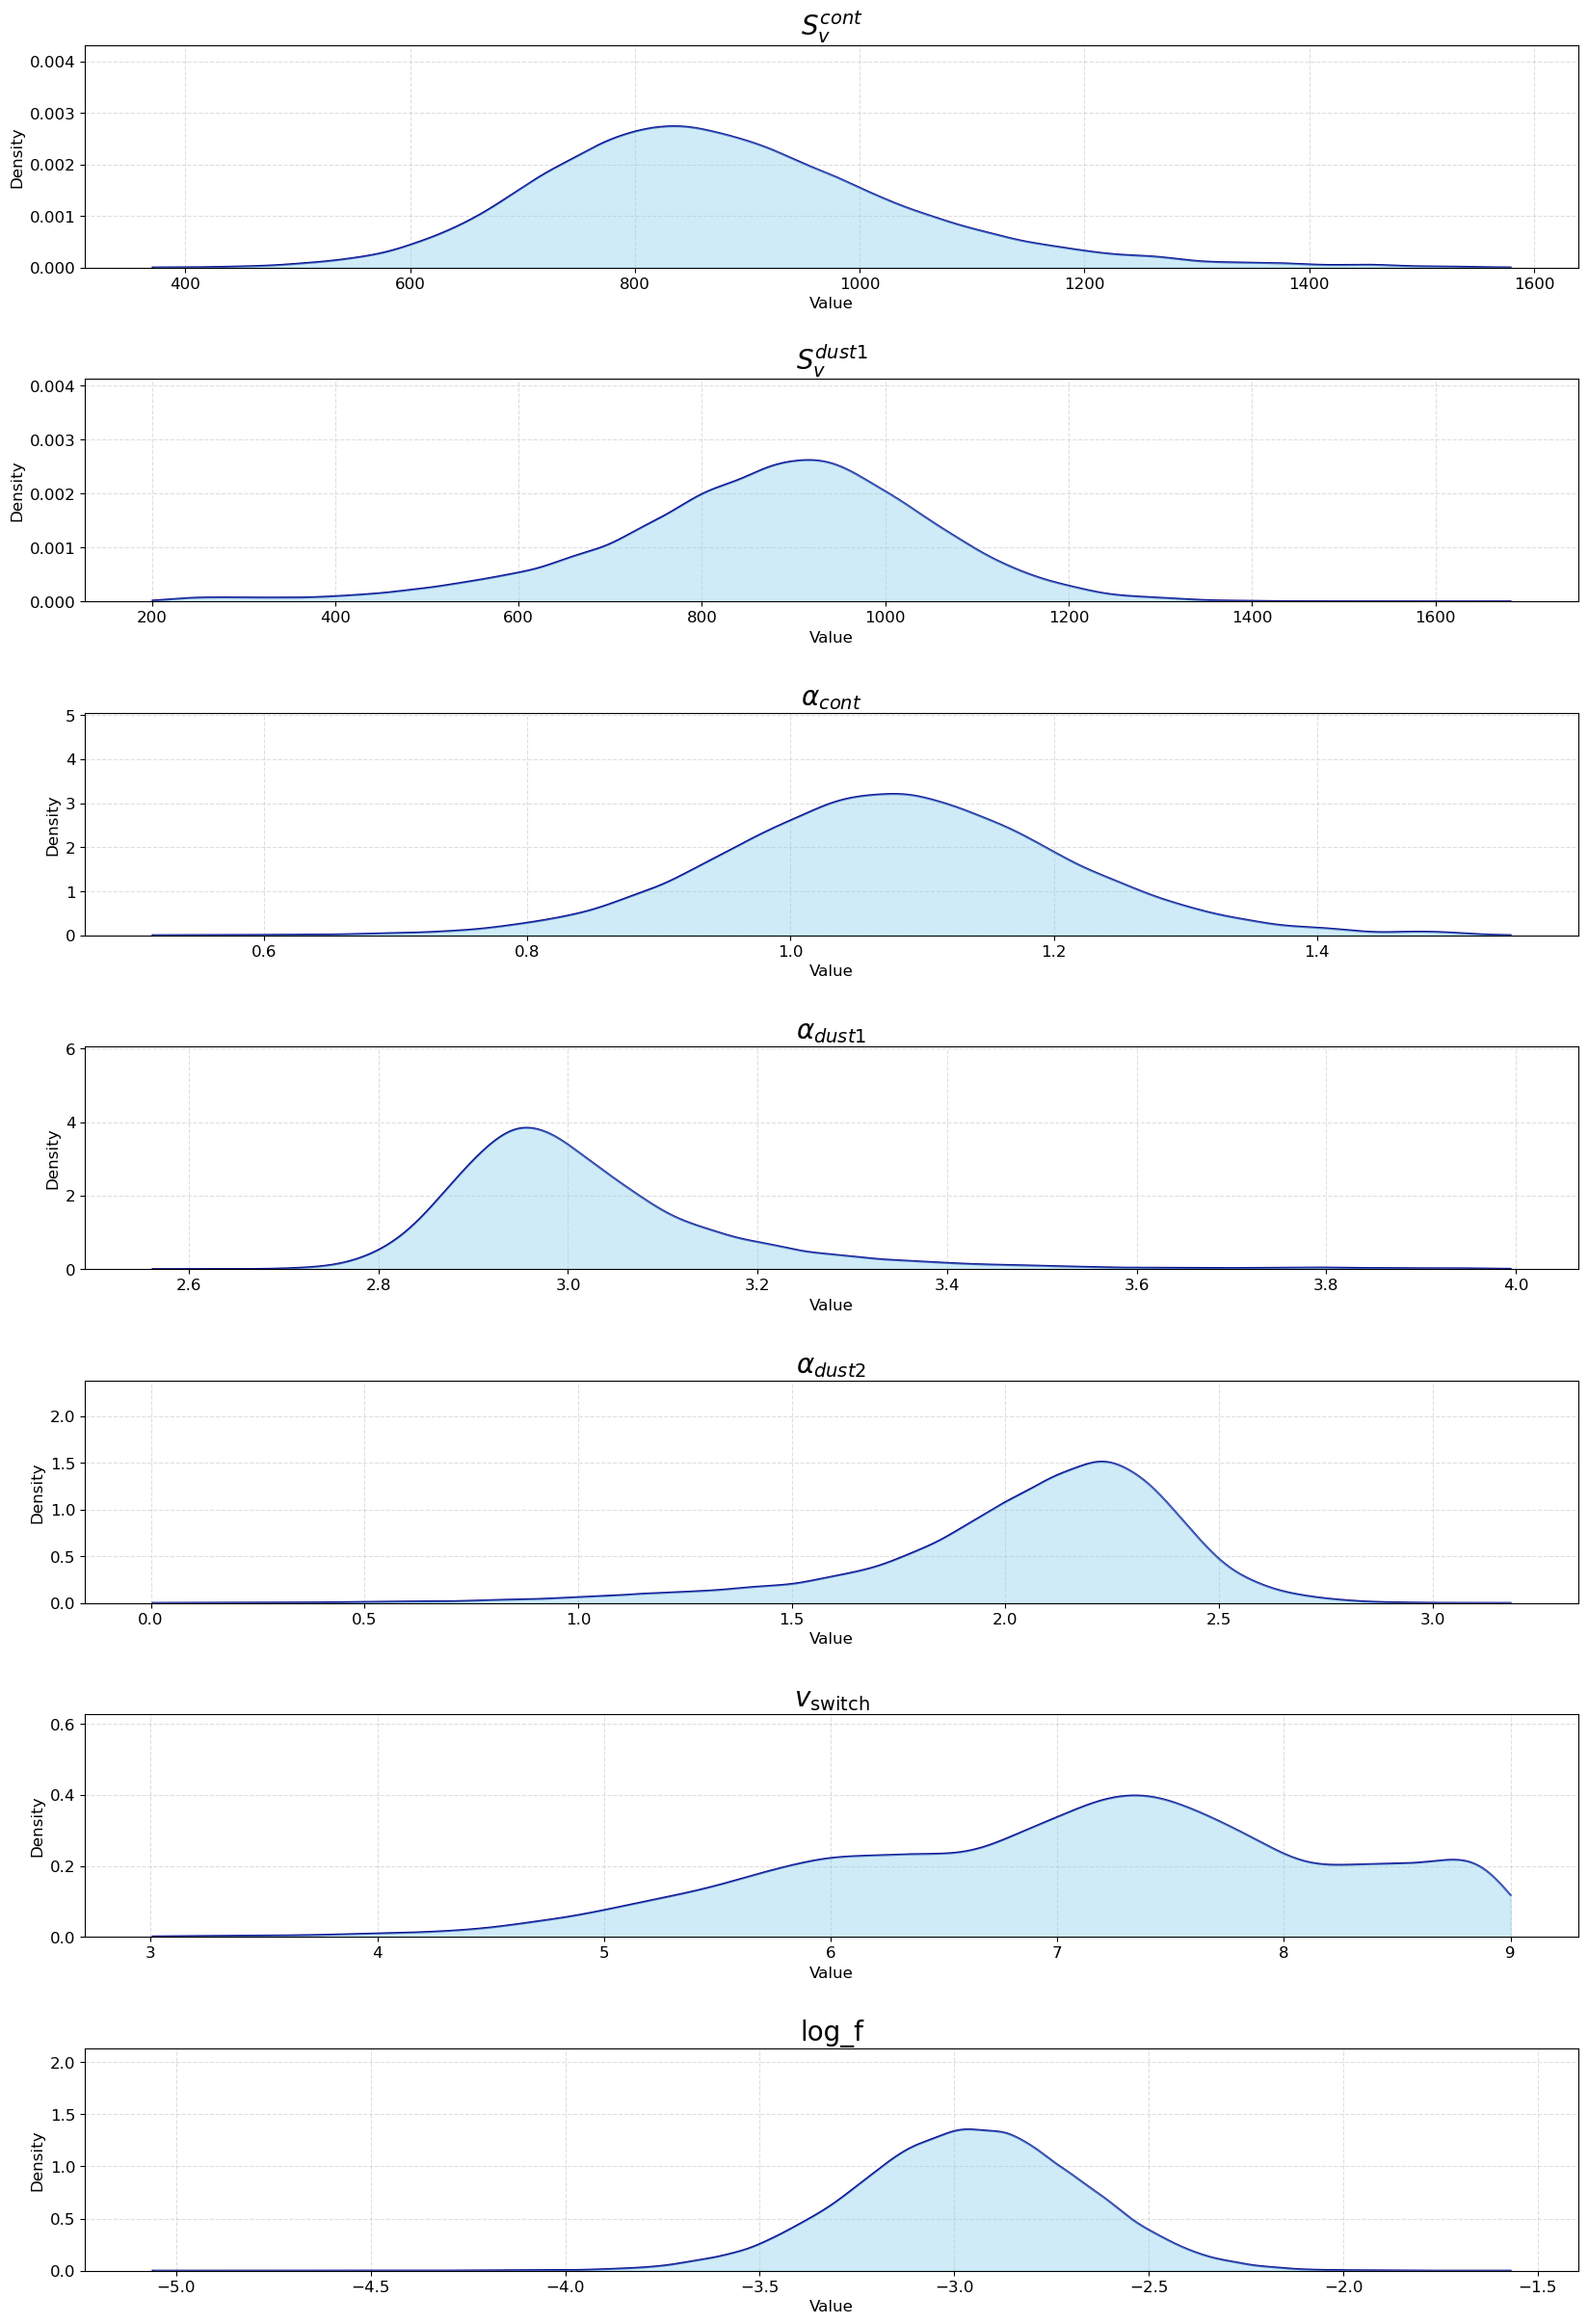

In [185]:
fig, axs = plt.subplots(7,1,figsize=(20,30))
plt.subplots_adjust(hspace=.5)



for num in range(len(labels)):
    data = [x[num] for x in flat_all_samples]
    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    kde_vals = kde(x_vals)
    # Plot the KDE
    axs[num].plot(x_vals, kde_vals, color="darkblue", label="KDE",zorder=2)
    axs[num].fill_between(x_vals, kde_vals, color="skyblue", alpha=0.4,zorder=2)
    axs[num].set_ylabel('Density',fontsize=12)
    axs[num].set_xlabel('Value',fontsize=12)
    axs[num].grid(alpha=.4,ls='--',zorder=0)
    axs[num].tick_params(axis='both',labelsize=12)


    axs[num].set_ylim(0,axs[num].get_ylim()[1]*1.5)

    axs[num].set_title(labels[num],fontsize=20)


100%|██████████| 5000/5000 [00:08<00:00, 602.83it/s]


[237.89664515 265.62216532 198.58921966 250.7851052  131.07896791
 188.67633575 101.77718407]
converged!


  0%|          | 0/5000 [00:00<?, ?it/s]/opt/miniconda3/envs/disker/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:08<00:00, 622.14it/s]


[218.9043983  253.71099363 181.71373398 224.58191192 142.55273172
 180.16155709  98.11416799]
converged!


/var/folders/vy/3w_cyymn26g4jzqfnt1dv5xm0000gn/T/ipykernel_76880/2435031740.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  corner_fig.show()


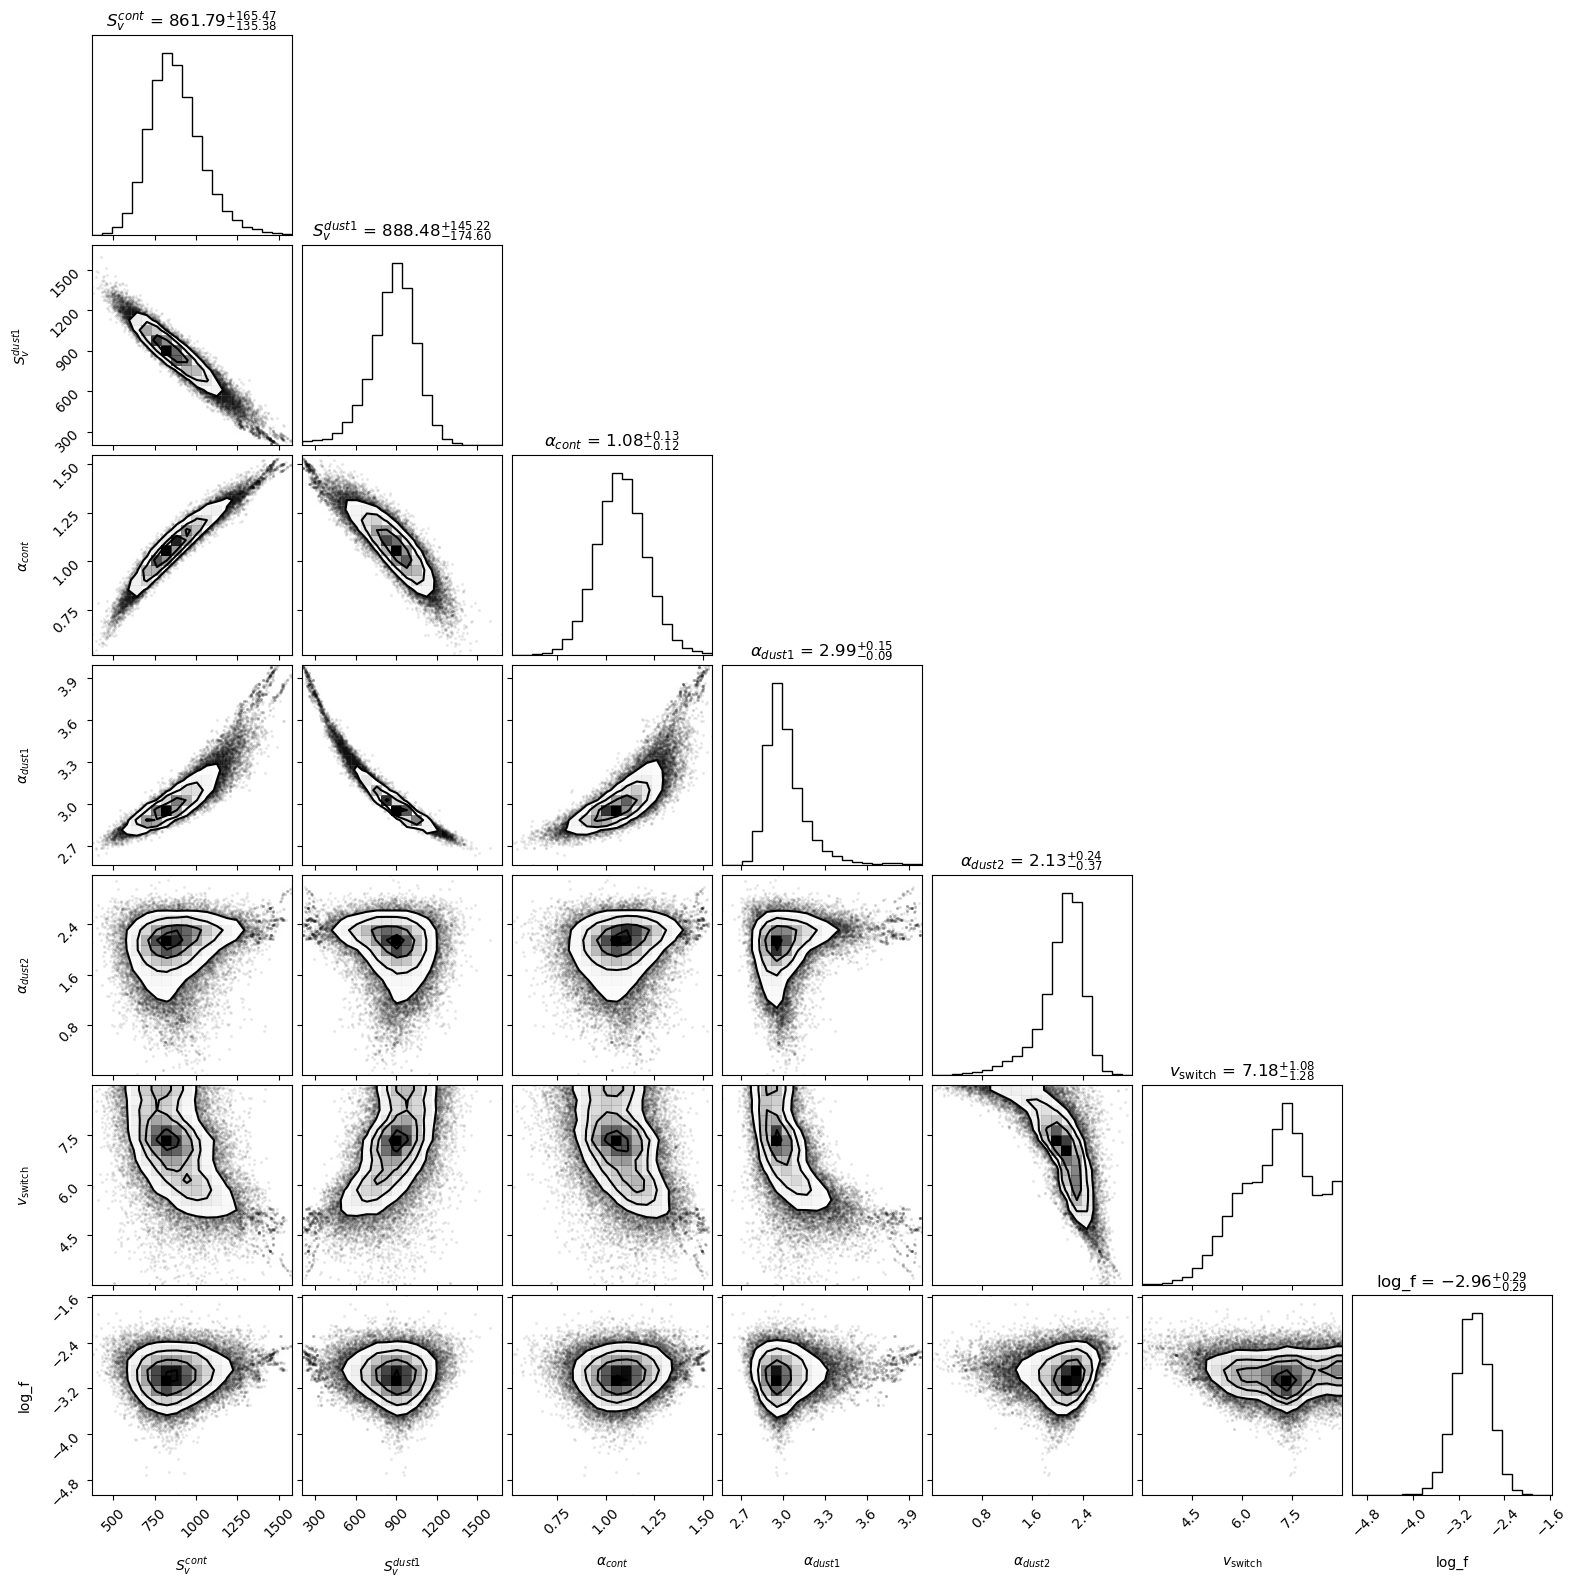

In [147]:
all_samples = boot_wrapper(data_version,mcmc_nu,mcmc_Snu,mcmc_Snu_err,n_bootstrap=2,plot=False)

## Saving

In [366]:
# save output to pdf with all diagnostic figures
save = True
if save == True:
    with PdfPages(f'/Users/calebpainter/Downloads/research/Disks/plots/combined_figs_{ndim}_model_{file_type}_file_num_{file_number}_{archive}_archive.pdf') as pdf:
        pdf.savefig(chains_fig)  # Save figure 1
        pdf.savefig(corner_fig)  # Save figure 2
        pdf.savefig(plotting_fig)  # Save figure 3

    # record model parameter fits to df
    model_data_combos_df.loc[len(model_data_combos_df)] = [data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err, model_type, ndim, result_params_dict, chi2]
    model_data_combos_df.to_csv('/Users/calebpainter/Downloads/research/Disks/codes/model_data_combos_df.csv')
    model_data_combos_df.head()

In [367]:
model_data_combos_df.head()

,Data Files,Frequencies,Intensities,Errors,Model,Dimensions,Parameter Values,X2
0,"{'File Type:': 'vis', 'Non-VLA Archive and Cut...","[45.64033321967027, 41.800420727890454, 33.960...","[3056.4907348059496, 2637.0086532650935, 1637....","[107.18342158126961, 72.76120731371293, 36.453...",three power law,7,"{'$S_v^{cont}$': 917.198522706243, '$S_v^{dust...",504.985827
1,"{'File Type:': 'img', 'Non-VLA Archive and Cut...","[44.996431036144266, 46.996316857342926, 40.99...","[3539.9827565183077, 3656.6408224540523, 2321....","[503.0566862291249, 514.3564258670333, 299.620...",three power law,7,"{'$S_v^{cont}$': 864.9030683567005, '$S_v^{dus...",326.922245
2,"{'File Type:': 'img', 'Non-VLA Archive and Cut...","[44.996431036144266, 46.996316857342926, 40.99...","[3539.9827565183077, 3619.403090228577, 2321.7...","[503.0566862291249, 509.3168649573543, 299.620...",three power law,7,"{'$S_v^{cont}$': 864.3066552960811, '$S_v^{dus...",328.015433
3,"{'File Type:': 'img', 'Non-VLA Archive and Cut...","[44.996431036144266, 46.996316857342926, 40.99...","[3424.513492015081, 4050.0020902760016, 2422.7...","[481.67400368291055, 555.0500862509865, 297.97...",three power law,7,"{'$S_v^{cont}$': 892.2121261688894, '$S_v^{dus...",313.056049
4,"{'File Type:': 'img', 'Non-VLA Archive and Cut...","[44.996431036144266, 46.996316857342926, 40.99...","[3596.7893203288254, 3940.037288832918, 2508.5...","[511.8366397608265, 548.7498443377738, 308.570...",three power law,7,"{'$S_v^{cont}$': 861.4904035060304, '$S_v^{dus...",290.495567


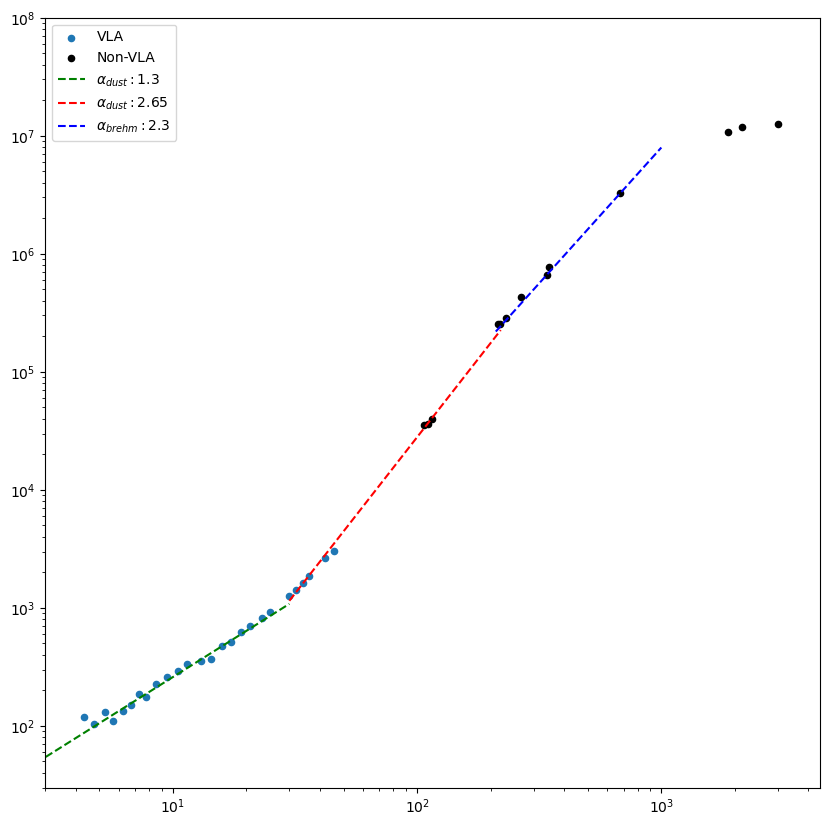

In [125]:

plt.figure(figsize=(10,10)) 
plt.scatter(nu_vis/(10**9), Snu_vis,s=20,label='VLA')
plt.errorbar(nu_vis/(10**9), Snu_vis,err_Snu_vis/(10**6),fmt='none')

plt.scatter(nu_non_vla,snu_non_vla*(10**6),s=20,color='black',label='Non-VLA')
plt.errorbar(nu_non_vla,snu_non_vla*(10**6),snu_err_non_vla,color='black',fmt='none')

plt.xscale('log')
plt.yscale('log')


nus = np.linspace(0,30,30)
dust_power = 1.3
dust_scale = 13
dust_sv = dust_scale * nus ** dust_power
plt.plot(nus,dust_sv,color='green',ls='--',label=r'$\alpha_{dust}:$'+ f'{dust_power}',)



nus = np.linspace(30,220,100)
dust_power = 2.65
dust_scale = .14
dust_sv = dust_scale * nus ** dust_power
plt.plot(nus,dust_sv,color='red',ls='--',label=r'$\alpha_{dust}:$'+ f'{dust_power}',)

nus = np.linspace(210,1000,800)
brehm_power = 2.3
brehm_scale = 1
brehm_sv = brehm_scale * nus ** brehm_power

# combined_sv = brehm_sv + dust_sv


plt.plot(nus,brehm_sv,color='blue',ls='--',label=r'$\alpha_{brehm}:$'+ f'{brehm_power}')
# plt.plot(nus,combined_sv,color='purple',label=r'combined')

plt.ylim(30,10e7)
plt.xlim(left=3)

plt.legend(loc='upper left')

plt.show()
